In [45]:
# Pacotes úteis
import matplotlib.pyplot as plt  # para os gráficos
import numpy as np  # para operações matemáticas

# %matplotlib notebook
# %matplotlib ipympl

# opções de figuras
plt.rcParams["font.family"] = ["serif"]
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["text.usetex"] = True

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Definição do Problema
Devemos simular a vibração de um poste de semáforo do tipo braço projetado que esteja balançando ao vento sob as condições presentes na avenida Dante Michelini, Vitória-ES.

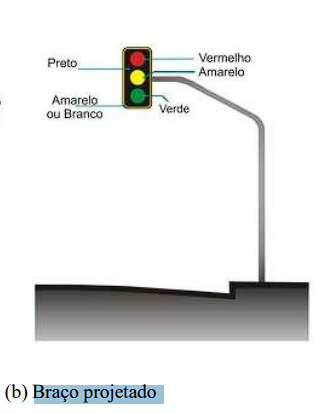



## Modelagem mátemática
<img src=croqui.svg width="500" length="500" style = "display:block; margin-left: auto; margin-right: auto">
As dimensões de postes do tipo estudado são:

| Simbolos | Dimensões|
|---|---|
| H | 5,5 m |
| L | 4,7 m |
| D | 0,114 m|
| t | 0,0045 m|

**O braço tem dimensões diferentes do poste engastado.

Foi escolhido utilizar um modelo de 6 graus de liberdade baseado na viga de Euler-Bernulli.
<img src=Frame1.svg width="800" style = "display: block; margin-left: auto; margin-right: auto">

In [46]:
# Defininido as matrizes de massa, rigidez e transformação
def StiffnessFrame(E, A, I, L):
    """
    Calcula a matriz de rigidez de um elemento de pórtico.

    Parâmetros:
    E (float): Módulo de elasticidade do material.
    A (float): Área da seção transversal do elemento.
    I (float): Momento de inércia da seção transversal do elemento.
    L (float): Comprimento do elemento.

    Retorna:
    numpy.ndarray: Matriz de rigidez do elemento de pórtico.
    """
    K = (
        E
        * I
        / (L**3)
        * np.array([
            [A * (L**2) / I, 0, 0, -A * (L**2) / I, 0, 0],
            [0, 12, 6 * L, 0, -12, 6 * L],
            [0, 6 * L, 4 * (L**2), 0, -6 * L, 2 * (L**2)],
            [-A * (L**2) / I, 0, 0, A * (L**2) / I, 0, 0],
            [0, -12, -6 * L, 0, 12, -6 * L],
            [0, 6 * L, 2 * (L**2), 0, -6 * L, 4 * (L**2)],
        ])
    )
    return K


def MassFrame(rho, A, L):
    """
    Calcula a matriz de massa para um elemento de pórtico.

    Parâmetros:
    rho (float): Densidade do material.
    A (float): Área da seção transversal do elemento do pórtico.
    L (float): Comprimento do elemento do pórtico.

    Retorna:
    numpy.ndarray: Uma matriz de massa 6x6 para o elemento do pórtico.
    """
    M = (
        rho
        * A
        * L
        / (420)
        * np.array([
            [140, 0, 0, 70, 0, 0],
            [0, 156, 22 * L, 0, 54, -13 * L],
            [0, 22 * L, 4 * (L**2), 0, 13 * L, -3 * (L**2)],
            [70, 0, 0, 140, 0, 0],
            [0, 54, 13 * L, 0, 156, -22 * L],
            [0, -13 * L, -3 * (L**2), 0, -22 * L, 4 * (L**2)],
        ])
    )
    return M


def TransformationMatrix(s_theta, c_theta):
    """
    Gera uma matriz de transformação para um dado seno e cosseno de um ângulo.
    Parâmetros:
    s_theta (float): Seno do ângulo.
    c_theta (float): Cosseno do ângulo.
    Retorna:
    numpy.ndarray: Uma matriz de transformação 6x6.
    """
    T = np.array([
        [c_theta, s_theta, 0, 0, 0, 0],
        [-s_theta, c_theta, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, c_theta, s_theta, 0],
        [0, 0, 0, -s_theta, c_theta, 0],
        [0, 0, 0, 0, 0, 1],
    ])
    return T


In [47]:
# Propriedades mecânicas do poste (Aço SAE 1010).
E = 205e3  # Módulo de elasticidade (MPa)
rho = 7850  # Densidade (kg/m³)

# Dimensões do poste.
H = 4.90  # Altura (m)
L = 4.70  # Comprimento (m)
t = 0.0045  # Espessura (m)
D = 0.114  # Diâmetro (m)
A = np.pi * (D**2 - (D - 2 * t) ** 2) / 4  # Área (m²)
I = np.pi * (D**4 - (D - 2 * t) ** 4) / 64  # Inércia (m⁴)

# Dimensões do semáforo
m_sem = 15  # Massa (kg)
h = 1.1  # Altura (m)
l = 0.5  # largura (m)
I_sem = l * h**3 / 12  # Inércia de área (m⁴)
A_sem = l * h  # Área (m²)
J_sem = m_sem * h**2 / 12  # Inércia de massa (kg.m²)

In [48]:
def initialize_section(
    K_global: np.ndarray,
    M_global: np.ndarray,
    start_node: int,
    n_elements: int,
    dofs: int,
    L_section: float,
    theta_deg: float,
    E: float,
    A: float,
    I: float,
    rho: float,
):
    """
    Adiciona uma seção de elementos à matriz global K e M.

    Parâmetros:
    K_global (np.ndarray): Matriz de rigidez global.
    M_global (np.ndarray): Matriz de massa global.
    start_node (int): Índice do nó inicial da seção.
    n_elements (int): Número de elementos na seção.
    dofs (int): Graus de liberdade por nó.
    L_section (float): Comprimento total da seção.
    theta_deg (float): Ângulo da seção em graus.
    E, A, I, rho: Propriedades do material e geométricas.

    Retorna:
    tuple: (K_global atualizada, M_global atualizada, novo_start_node)
    """
    theta = np.radians(theta_deg)
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    T = TransformationMatrix(s_theta, c_theta)
    L_element = L_section / n_elements

    for i in range(n_elements):
        # Calcula as matrizes do elemento
        K_element = StiffnessFrame(E, A, I, L_element)
        M_element = MassFrame(rho, A, L_element)

        # Transforma para coordenadas globais
        K_element_global = T.T @ K_element @ T
        M_element_global = T.T @ M_element @ T

        # Índices na matriz global (6 DOFs por elemento)

        inicio = dofs * (start_node + i)
        fim = inicio + 2 * dofs

        # Monta na matriz global
        K_global[inicio:fim, inicio:fim] += K_element_global
        M_global[inicio:fim, inicio:fim] += M_element_global

    novo_start_node = start_node + n_elements
    return K_global, M_global, novo_start_node


# Inicializa matrizes globais
n_elementos_vertical = 1
n_elementos_horizontal = 1
total_nos = n_elementos_vertical + n_elementos_horizontal + 1  # Nós totais
dofs = 3  # Graus de liberdade
total_dofs = dofs * total_nos
K = np.zeros((total_dofs, total_dofs))
M = np.zeros((total_dofs, total_dofs))

# Adiciona seção vertical (ângulo 90°)
K, M, start_node = initialize_section(
    K, M, start_node=0, n_elements=n_elementos_vertical, dofs=dofs, L_section=4.90, theta_deg=90, E=E, A=A, I=I, rho=rho
)

# Adiciona seção horizontal (ângulo 0°)
K, M, _ = initialize_section(
    K,
    M,
    start_node=start_node,
    n_elements=n_elementos_horizontal,
    dofs=dofs,
    L_section=4.70,
    theta_deg=0,
    E=E,
    A=A,
    I=I,
    rho=rho,
)

# Adiciona massa do semáforo no último nó
M[-3, -3] += 15  # kg
M[-2, -2] += 15  # kg
M[-1, -1] += J_sem  # kg.m²


#### Condições de contorno:

##### Engastada:
$u_0$ = 0;

$u_1$ = 0;

$u_2$ = 0;

In [49]:
# Engastado no inicio.
K = np.delete(K, (0, 1, 2), axis=0)
K = np.delete(K, (0, 1, 2), axis=1)
M = np.delete(M, (0, 1, 2), axis=0)
M = np.delete(M, (0, 1, 2), axis=1)


### Amortecimento Proporcional


In [50]:
alpha = 0.01  # amortecimento proporcional
beta = 1e-7  # amortecimento proporcional

C = alpha * M + beta * K  # amortecimento proporcional


## Análise Modal


In [51]:
# 1: L^-1:
L_chol = np.linalg.cholesky(M)
L_chol_inv = np.linalg.inv(L_chol)

# 2: K_tiu
K_tiu = np.dot(L_chol_inv, np.dot(K, L_chol_inv.transpose()))

# 3: problema de autovalor
a, b = np.linalg.eig(K_tiu)  # a são autovalores e b autovetores (cada coluna de b é 1 autovetor)

wn = np.sqrt(a)  # vetor com as frequências naturais
v = b

# ordenar da menor para a maior frequência
v = v[:, np.argsort(wn)]
wn = np.sort(wn)

P = v  # a matriz P vai ser a própria matriz v que já contém todos os autovetores

S = np.dot(L_chol_inv.transpose(), P)  # da coordenada x para r
S_inv = np.dot(np.transpose(P), L_chol.transpose())  # da coordenada r para x

zeta_i = alpha / (2 * wn) + beta * wn / 2

print("Fatores de amortecimento:", zeta_i[0:4], "\n")
print("Frequências Naturais [Hz]:", wn[0:4] / 2 / np.pi, "\n")
# print("Frequências Naturais Analiticamente [Hz]:", w_alalitico / 2 / np.pi, "\n")


Fatores de amortecimento: [0.6107794  0.22353032 0.03773598 0.01625075] 

Frequências Naturais [Hz]: [0.00130288 0.00356003 0.02108796 0.04896855] 



### Modos de Vibrar

In [52]:
# # Definição dos nós:
# Coordenadas dos nós verticais:
y_vertical = np.linspace(0, H, n_elementos_vertical + 1)  # [0, H/3, 2H/3, H]
x_vertical = np.zeros_like(y_vertical)  # [0, 0, 0, 0]

# Coordenadas dos nós horizontais:
x_horizontal = np.linspace(0, L, n_elementos_horizontal + 1)[1:]  # [L/4, L/2, 3L/4]
y_horizontal = np.full_like(x_horizontal, H)  # [H, H, H]

# Combina as coordenadas
x_nos = np.concatenate([x_vertical, x_horizontal])  # 7 nós
y_nos = np.concatenate([y_vertical, y_horizontal])  # 7 nós

print("nos x:\n", x_nos)
print("nos y:\n", y_nos)

nos x:
 [0.  0.  4.7]
nos y:
 [0.  4.9 4.9]


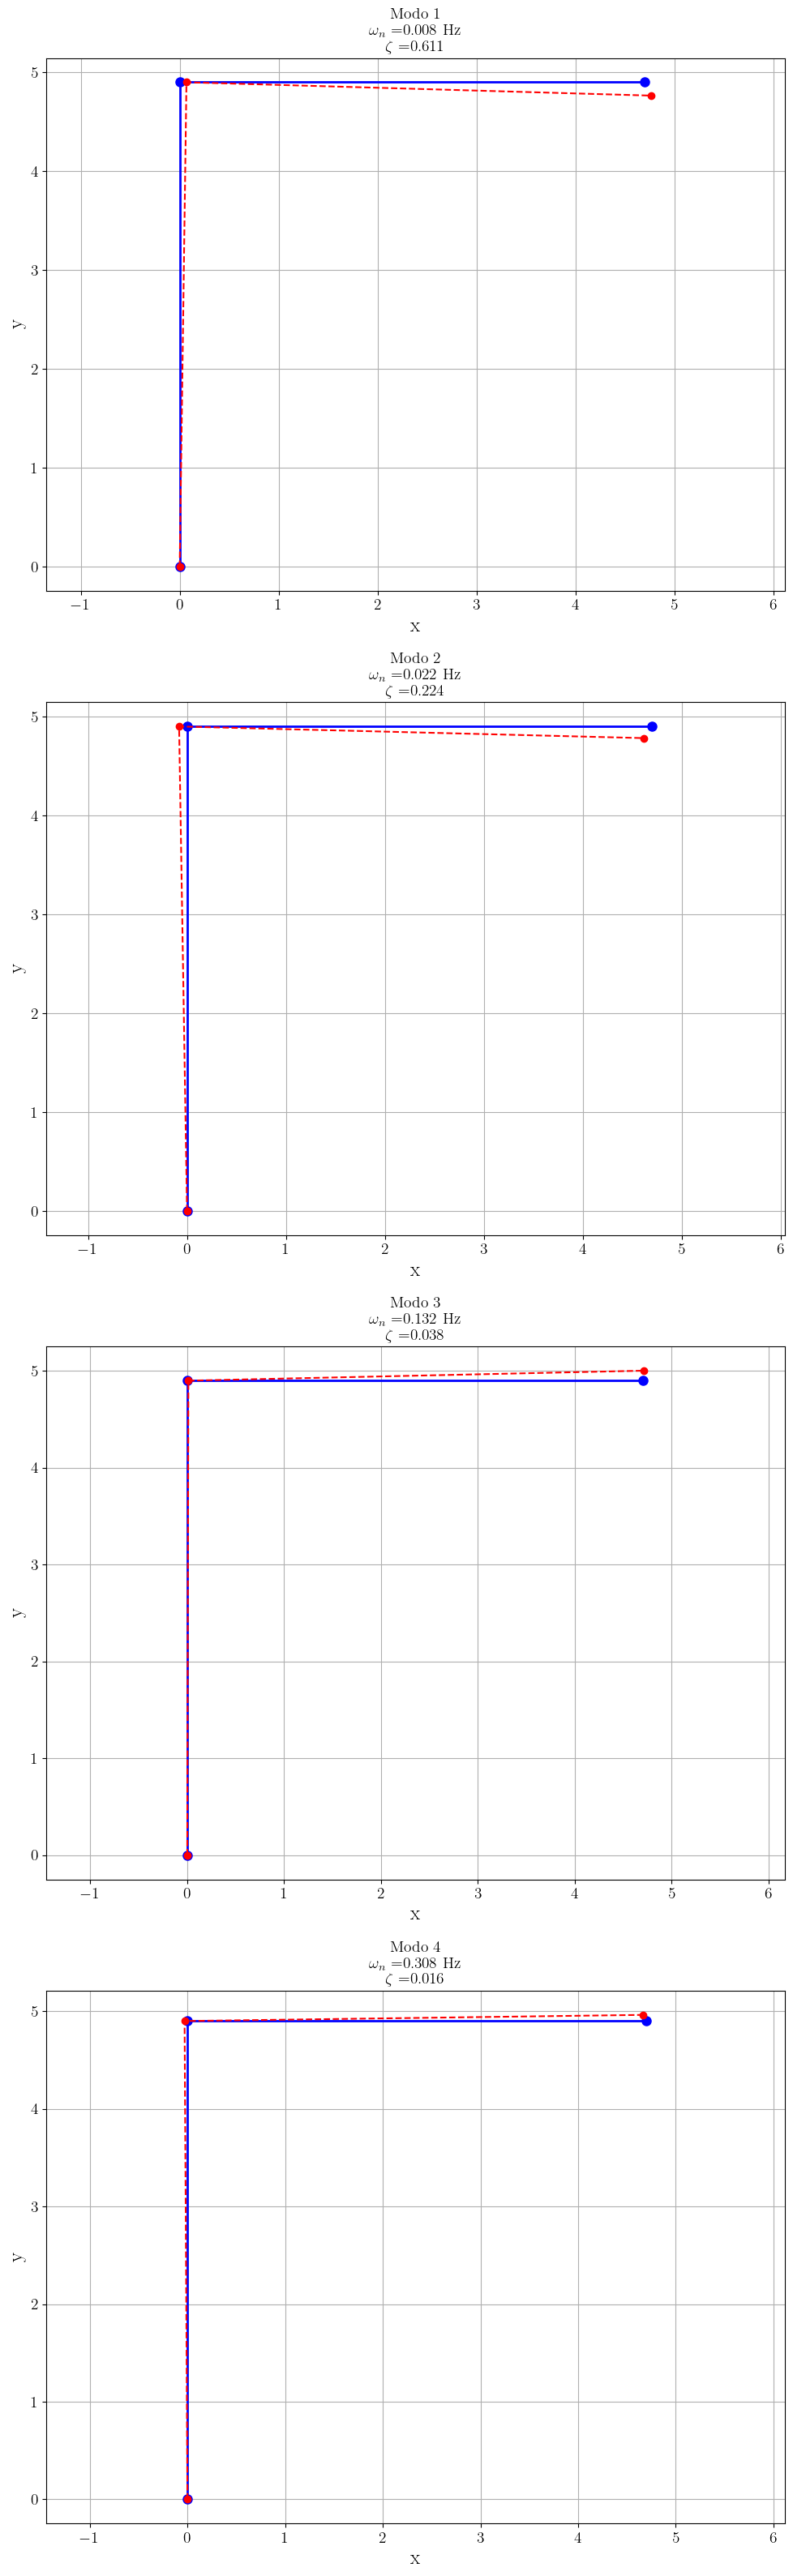

In [53]:
# # Plot dos modos de Vibrar
n_modos = 4
scale = 1  # Fator de escala para visualização

# Extrair deslocamentos em x e y
x_modo = np.zeros((total_nos - 1, n_modos))
y_modo = np.zeros((total_nos - 1, n_modos))

# Extrair deslocamentos (x, y, θ) para todos os modos
u_x = S[0::3, :n_modos]  # DOFs em x (shape: (total_nos, n_modos))
u_y = S[1::3, :n_modos]  # DOFs em y (shape: (total_nos, n_modos))


# Aplicar escala e ajustar dimensões para broadcasting
x_modo = x_nos[1:].reshape(-1, 1) + scale * u_x  # shape: (total_nos, n_modos)
y_modo = y_nos[1:].reshape(-1, 1) + scale * u_y

# Fixar o primeiro nó (suporte)
x_modo = np.insert(x_modo, 0, x_nos[0], axis=0)
y_modo = np.insert(y_modo, 0, y_nos[0], axis=0)

# Plotar
fig, axs = plt.subplots(n_modos, 1, figsize=(10, 8 * n_modos))
for i in range(n_modos):
    axs[i].plot(x_nos, y_nos, "-ob", linewidth=2, markersize=8, label="Nós")
    axs[i].plot(x_modo[:, i], y_modo[:, i], "--or", linewidth=1.5, markersize=6, label="Modo")
    axs[i].grid(True)
    axs[i].set_title(
        f"Modo {i + 1} \n" + r"$\omega_n$ =" + f"{wn[i]:.3f} Hz \n" + r"$\zeta$ =" + f"{zeta_i[i]:.3f}", fontsize=14
    )
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].axis("equal")

plt.tight_layout()
plt.show()


## Calculando as FRFs

In [54]:
def calculate_frequency_response(M, C, K, w):
    """
    Calcula a resposta em frequência de um sistema de múltiplos graus de liberdade (MDoF).

    Parâmetros:
    ----------
    M : numpy.ndarray
        Matriz de massa (n x n).
    C : numpy.ndarray
        Matriz de amortecimento (n x n).
    K : numpy.ndarray
        Matriz de rigidez (n x n).
    w : numpy.ndarray
        Vetor de frequências em Hz.

    Retorno:
    -------
    H : numpy.ndarray
        Matriz de resposta em frequência (n x n x len(w)).
    """
    H = np.zeros((len(M), len(M), len(w)), dtype="complex")
    for n in range(0, len(w)):
        H[:, :, n] = np.linalg.inv(K - M * ((2 * np.pi * w[n]) ** 2) + complex(0, 1) * C * 2 * np.pi * w[n])
    return H


In [55]:
# Definimos os parâmetros amostrais
fs = 10  # taxa de amostragem
Np = 5000  # número de pontos
tf = (Np) / fs  # tempo total
t = np.linspace(0, tf, Np, endpoint=False)
n_window = Np // 4
n_fft = n_window
overl = n_window // 5
janela = "hann"

In [ ]:
w = np.linspace(0, fs / 2, int(Np / 2), endpoint=False)  # vetor freqência em Hz
H = calculate_frequency_response(M, C, K, w)

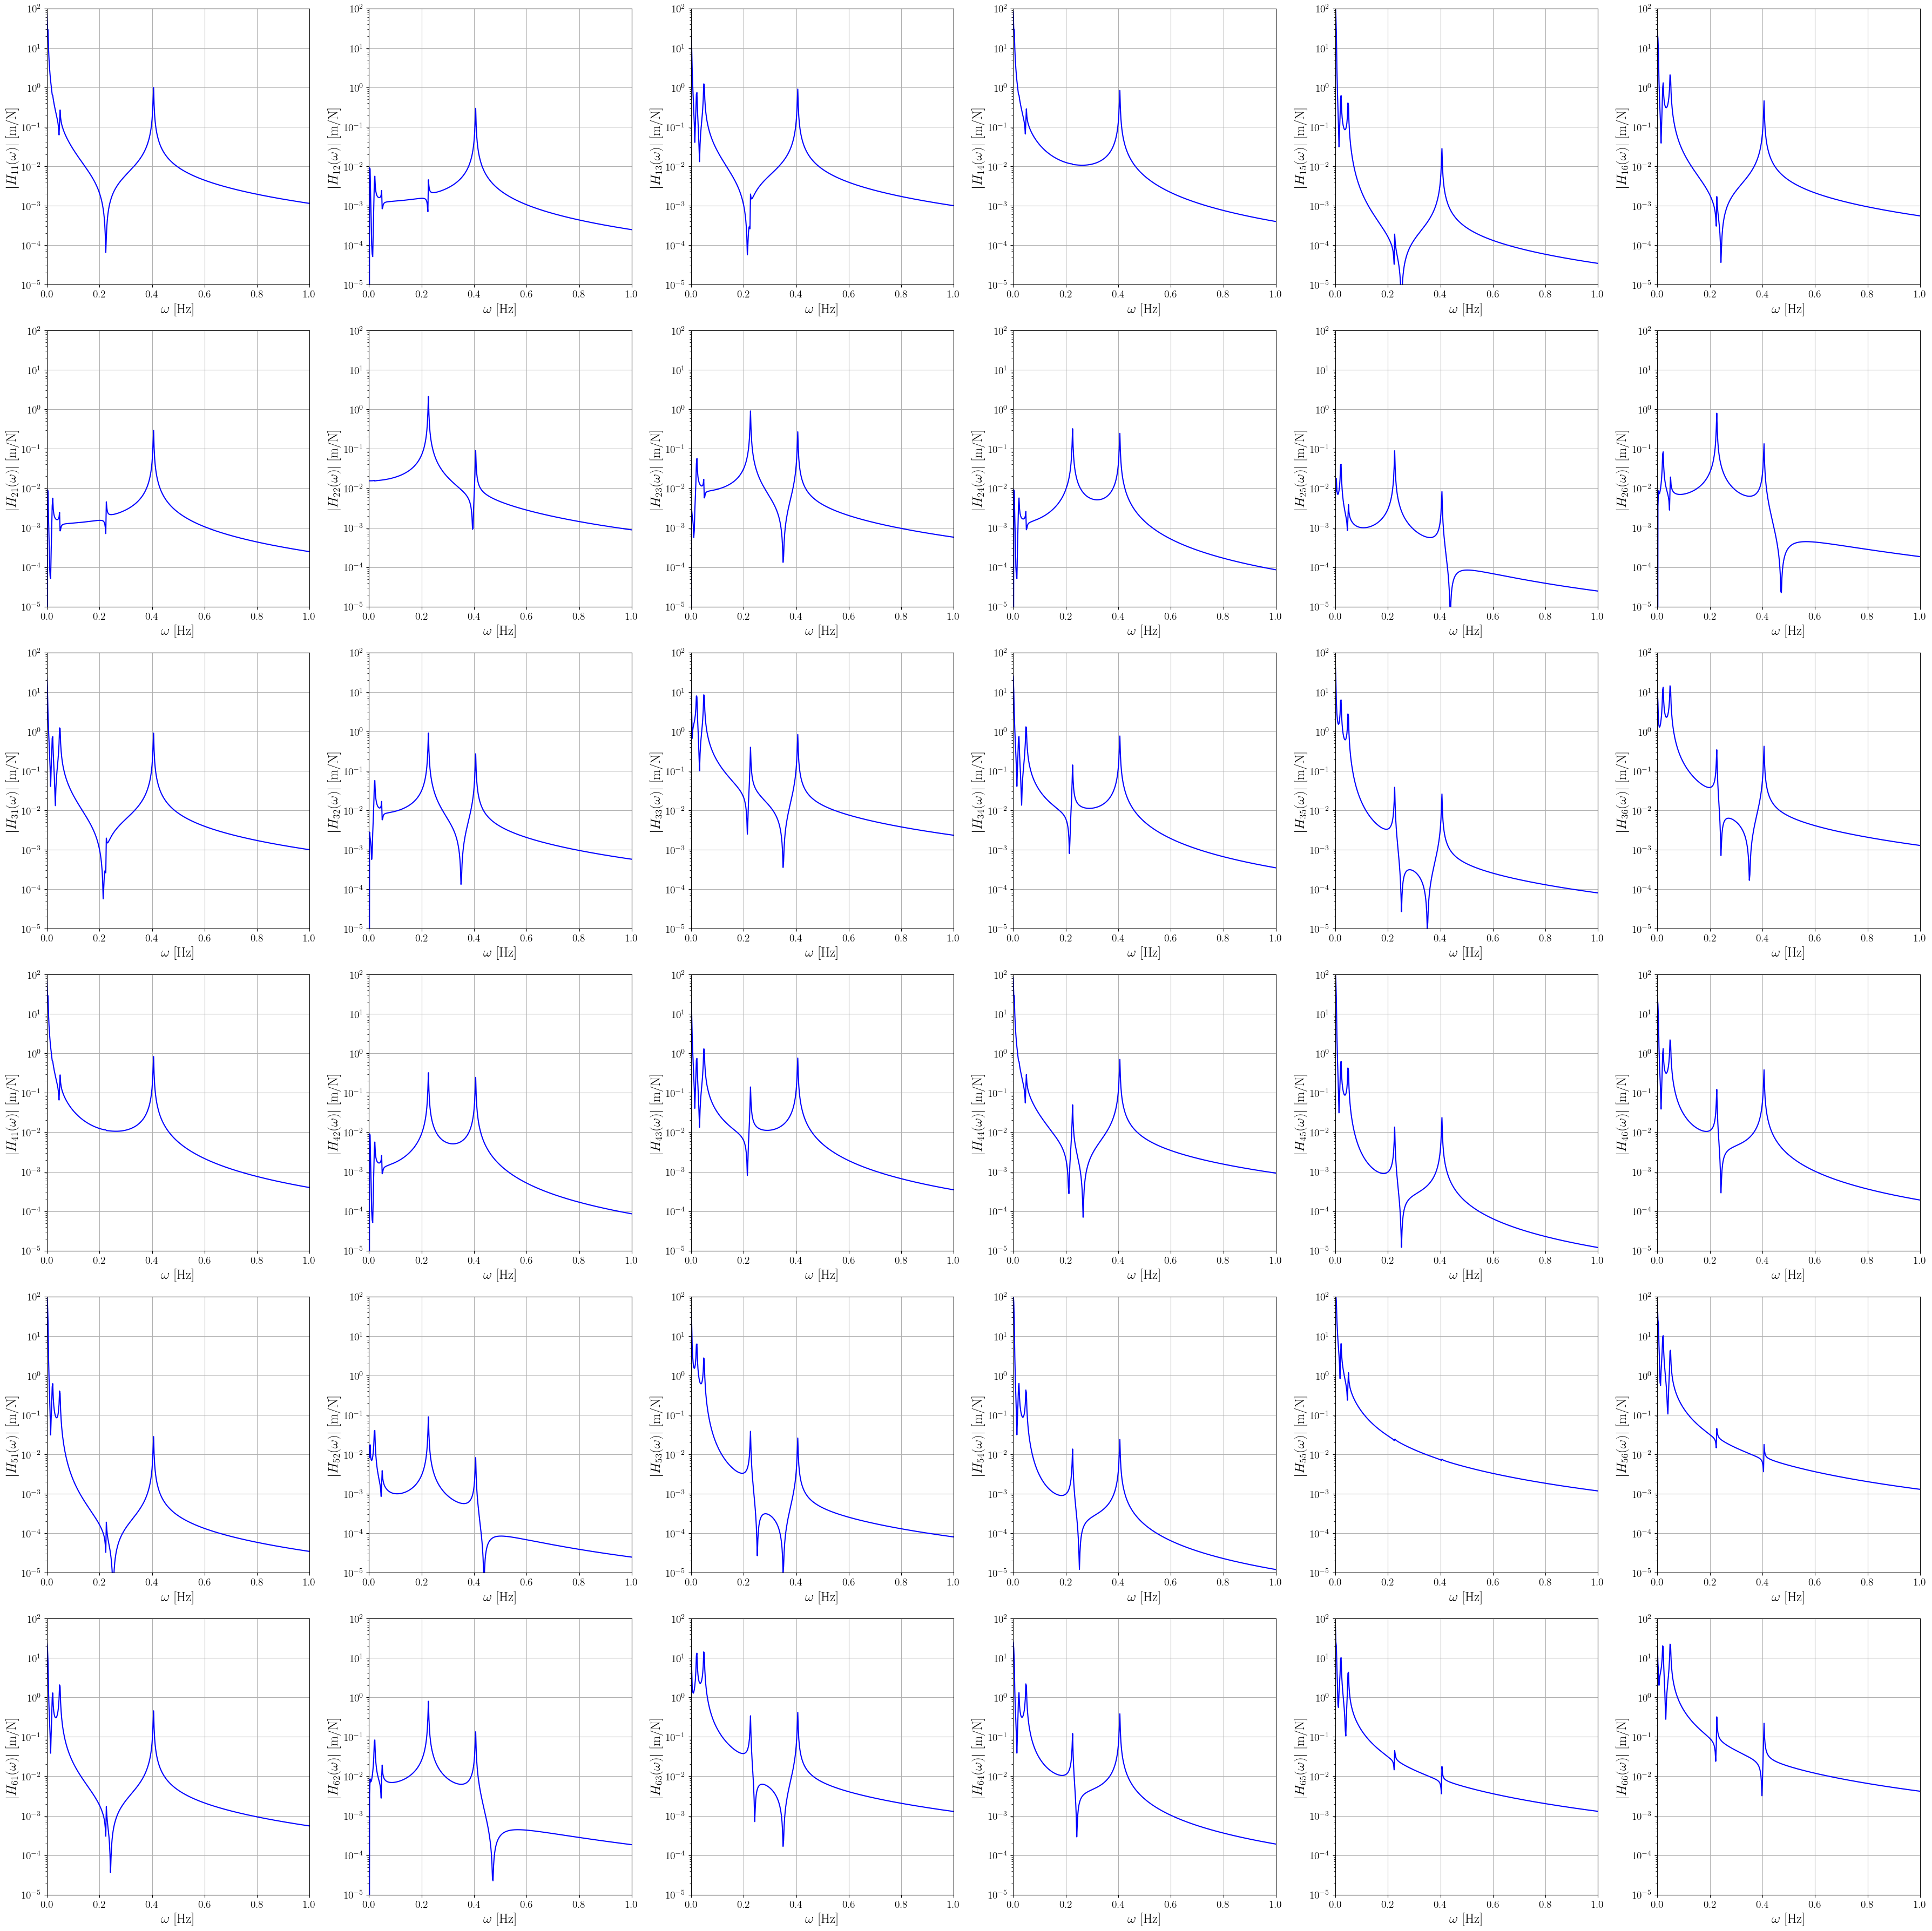

In [ ]:
def plot_n_frf(w, H, figsize=(6, 6)):
    """
    Plota a Função de Resposta em Frequência (FRF) para um sistema com n graus de liberdade.

    Parâmetros:
    ----------
    w : array-like
        Array de valores de frequência em Hz.
    H : ndarray
        Array multidimensional contendo os valores da FRF.
        H deve ter dimensões (n, n, len(w)), onde n é o número de graus de liberdade.
    figsize : tuple, opcional
        Tupla especificando o tamanho de cada subplot. O padrão é (6, 6).

    Retorno:
    -------
    Nenhum: Esta função não retorna nenhum valor. Ela exibe os gráficos.

    Notas:
    ------
    - A função cria uma grade de subplots com dimensões (n, n), onde n é o número de graus de liberdade.
    - Cada subplot corresponde à magnitude da FRF entre dois graus de liberdade.
    - O eixo x representa a frequência em Hz, e o eixo y representa a magnitude da FRF em m/N.
    - Os gráficos são exibidos em escala logarítmica para o eixo y.
    - O eixo x é limitado ao intervalo [0, 50] Hz.
    - O eixo y é limitado ao intervalo [1e-5, 1e-1] m/N.
    """
    fig, ax = plt.subplots(len(H), len(H), figsize=(len(H) * figsize[0], len(H) * figsize[1]))
    for i in range(len(H)):
        for j in range(len(H)):
            ax[i, j].grid(visible=True, which="major", axis="both")
            ax[i, j].semilogy(w, abs(H[i, j, :]), "b")  # Aqui H deve ser um array multidimensional
            ax[i, j].set(
                xlabel=r"$\omega$ [Hz]",
                ylabel=rf"$|H_{{{i + 1}{j + 1}}}(\omega)|$ [m/N]",
            )
            ax[i, j].set_xlim(0, 1)
            ax[i, j].set_ylim(1e-5, 100)
    plt.show()


plot_n_frf(w, H)

#### Plots da fase:

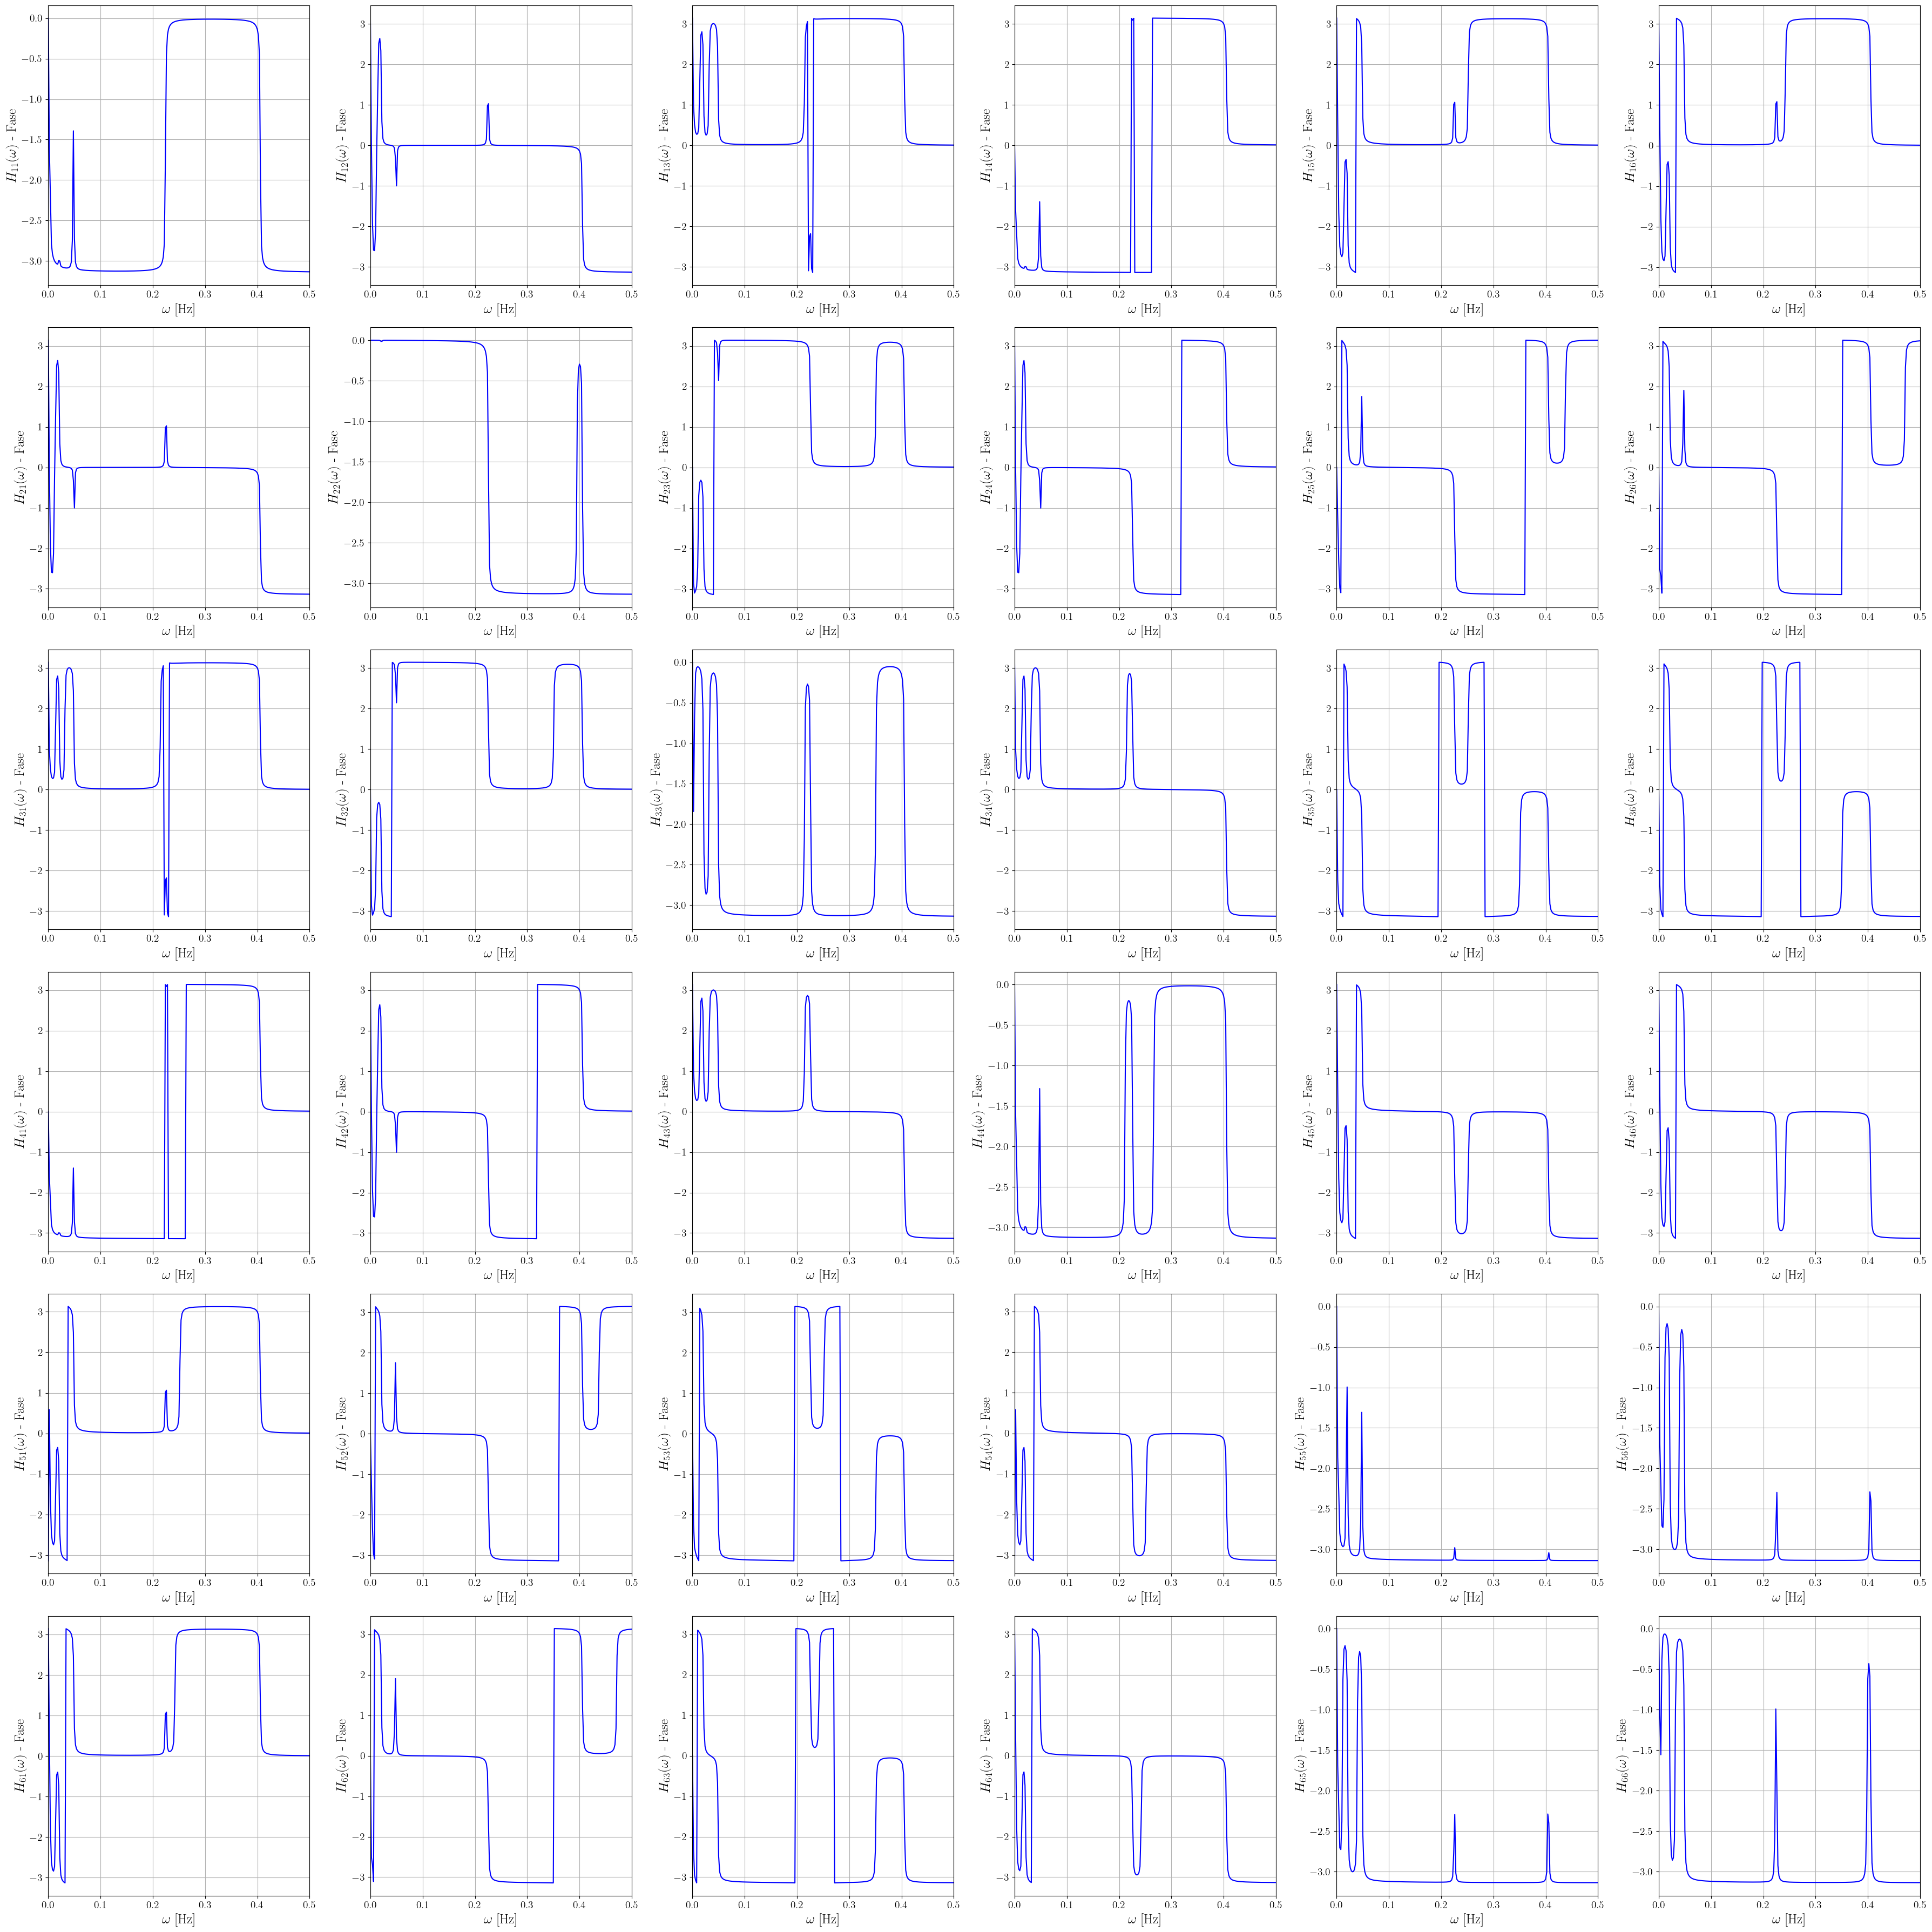

In [ ]:
def plot_n_phase(f2, H, figsize=(6, 6)):
    """
    Plota a fase das funções de resposta em frequência (FRF) para um sistema de n graus de liberdade.

    Parâmetros:
    -----------
    f2 : array-like
        Frequências em Hz.
    H : array-like
        Matriz de funções de resposta em frequência (FRF) complexas, onde H_exp[i, j, :] representa a FRF entre o i-ésimo e j-ésimo graus de liberdade.
    figsize : tuple, opcional
        Tamanho da figura (largura, altura) em polegadas. O padrão é (14, 6).

    Retorna:
    --------
    None
        A função não retorna nada. Ela exibe um gráfico com as fases das FRFs.
    """
    fig, ax = plt.subplots(
        len(H),
        len(H),
        figsize=(len(H) * figsize[0], len(H) * figsize[1]),
    )
    for i in range(len(H)):
        for j in range(len(H)):
            ax[i, j].grid(visible=True, which="major", axis="both")
            ax[i, j].plot(f2, np.angle(H[i, j, :]), "b")
            ax[i, j].set(
                xlabel=r"$\omega$ [Hz]",
                ylabel=f"$H_{{{i + 1}{j + 1}}}" + r"(\omega)$ - Fase",
            )
            ax[i, j].set_xlim(0, 0.5)
    plt.show()


plot_n_phase(w, H)

#### Plots da parte imaginária

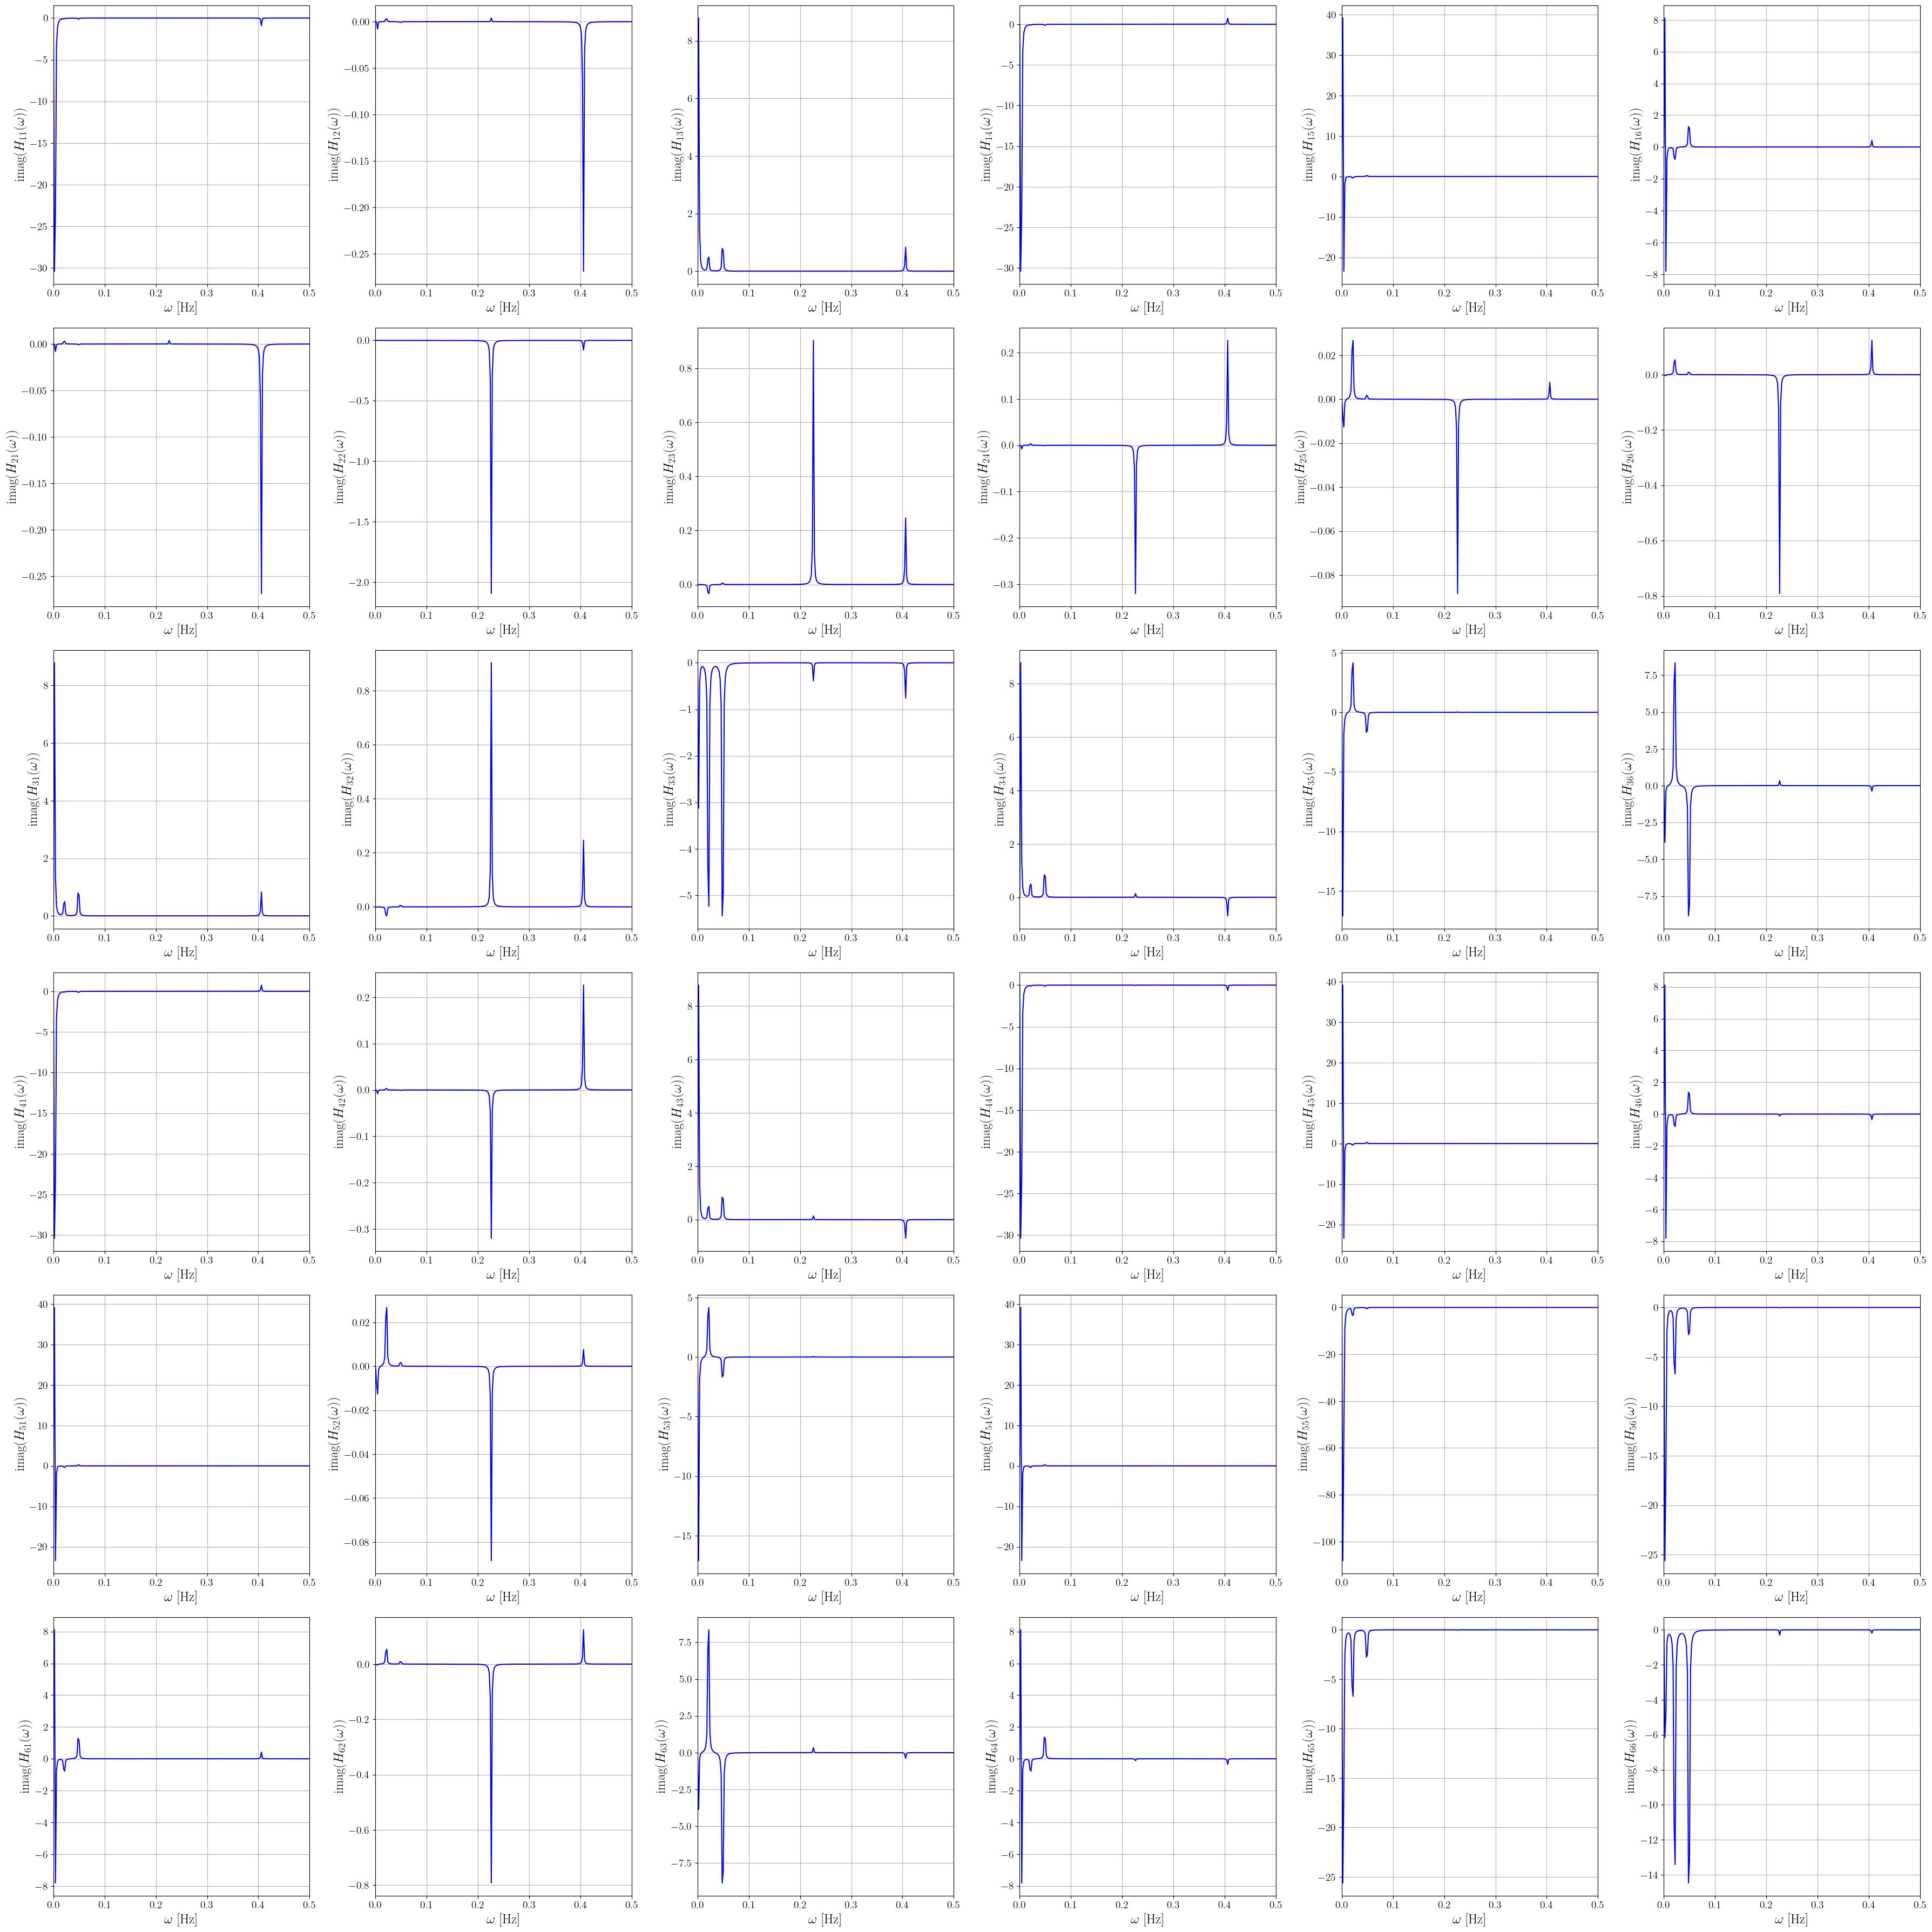

In [68]:
def plot_n_imaginary(f2, H, figsize=(6, 6)):
    """
    Plota as partes imaginárias de uma matriz de funções de transferência.

    Parâmetros:
    f2 (array-like): Frequências em Hz.
    H (array-like): Matriz de funções de transferência complexas.
    figsize (tuple, opcional): Tamanho da figura (largura, altura). Padrão é (14, 6).

    Retorna:
    None
    """
    fig, ax = plt.subplots(len(H), len(H), figsize=(len(H) * figsize[0], len(H) * figsize[1]))
    for i in range(len(H)):
        for j in range(len(H)):
            ax[i, j].grid(visible=True, which="major", axis="both")
            ax[i, j].plot(f2, np.imag(H[i, j, :]), "b")
            ax[i, j].set(
                xlabel=r"$\omega$ [Hz]",
                ylabel=f"imag($H_{{{i + 1}{j + 1}}}" + r"(\omega)$)",
            )
            ax[i, j].set_xlim(0, 0.5)
    plt.show()


plot_n_imaginary(w, H)

### Estimando parâmetros a partir da FRF utilizando modelo Modal (Line-fit)

In [ ]:
def estimate_delta(ww_local, H_local, Omega):
    index_Omega = np.where(ww_local == Omega)[0][0]
    H_omega = H_local[index_Omega,]
    Den = []
    Num = []
    ww_delta = []
    for index in range(0, len(ww_local)):
        if index == index_Omega:
            continue
        else:
            Den.append(H_local[index,] - H_omega)
            Num.append(ww_local[index,] ** 2 - Omega**2)
            ww_delta.append(ww_local[index,])
    Den = np.asarray(Den, dtype="complex")
    Num = np.asarray(Num, dtype="complex")
    ww_delta = np.asarray(ww_delta)
    delta = Num.reshape(
        -1,
    ) / Den.reshape(
        -1,
    )
    # print(delta)
    return ww_delta, delta


def moindre_carre(x, y):
    N = len(x)
    Sx = np.sum(x)
    Sy = np.sum(y)
    Sxx = np.sum(x * x)
    Sxy = np.sum(x * y)
    b = (Sxx * Sy - Sx * Sxy) / (N * Sxx - Sx**2)
    a = (N * Sxy - Sx * Sy) / (N * Sxx - Sx**2)
    return a, b


def line_fit(H_exp, freq, fmin, fmax):
    # H_exp: a FRF a ser estudada
    # freq: vetor frequência em Hz
    # fmin: frequência mínima do intervalo que se deseja analisar
    # fmax: frequência máxima do intervalo que se deseja analisar

    temp = np.argwhere(freq > fmin)  # Find the indices of array elements that are non-zero, grouped by element.
    index_low = temp[0, 0] - 1
    temp = np.argwhere(freq > fmax)  # Find the indices of array elements that are non-zero, grouped by element.
    index_high = temp[0, 0]

    H_local = H_exp[index_low:index_high]
    freq_local = freq[index_low:index_high]
    ww_local = 2 * np.pi * freq_local

    # In the case of insufficient number of samples
    N_pts = len(freq_local)
    Delta = np.zeros((N_pts - 1, N_pts), dtype="complex")
    ww_Delta = np.zeros((N_pts - 1, N_pts))

    # Dobson's method application
    for ind in range(0, N_pts):
        ww_delta, delta = estimate_delta(ww_local, H_local, ww_local[ind])
        Delta[:, ind] = delta
        ww_Delta[:, ind] = ww_delta

    tr = np.zeros((N_pts,))
    cr = np.zeros((N_pts,))
    ti = np.zeros((N_pts,))
    ci = np.zeros((N_pts,))

    # Best straight line finding
    for index in range(N_pts):
        a, b = moindre_carre(ww_Delta[:, index] ** 2, np.real(Delta[:, index]))
        tr[index,] = a
        cr[index,] = b
        a, b = moindre_carre(ww_Delta[:, index] ** 2, np.imag(Delta[:, index]))
        ti[index,] = a
        ci[index,] = b

    ur, dr = moindre_carre(ww_local**2, tr)
    ui, di = moindre_carre(ww_local**2, ti)
    p = ui / ur
    q = di / dr

    # Modal parameters calculation
    loss_factor = (q - p) / (1 + p * q)
    wr = np.sqrt(dr / ((p * loss_factor - 1) * ur))
    ar = -(wr**2) * (p * loss_factor - 1) / ((1 + p**2) * dr)
    br = ar * p
    B = ar + 1j * br

    # loss_factor/2: fator de amortecimento
    # wr: frequência natural
    # B: constante modal para o modo estudado (muda conforme mudo a posição entrada-saída)

    return (loss_factor / 2, wr, B)